## CNN model 

In [155]:
## setting random seed 

import random
random.seed(44)
print(random.random())

0.40853587925449375


## Gridsearch  over class_weights

In [28]:
## import modules
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from keras.utils import np_utils
from imblearn.over_sampling import RandomOverSampler
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
from keras import optimizers
from keras import losses
from tensorflow.keras.layers import AveragePooling2D
import cv2
from sklearn import metrics
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tensorflow.keras.initializers import he_uniform
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, balanced_accuracy_score
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
import matplotlib.pyplot as plt
from Evaluation import * 
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import balanced_accuracy_score


## loading data
x_train = np.load("created_data/MIAS/patches/MIAS_X_train_roi_multi.npy") / 255
y_train = np.load("created_data/MIAS/patches/MIAS_y_train_roi_multi.npy")
x_valid = np.load("created_data/MIAS/patches/MIAS_X_valid_roi_multi.npy") / 255
y_valid = np.load("created_data/MIAS/patches/MIAS_y_valid_roi_multi.npy") 
x_test = np.load("created_data/MIAS/patches/MIAS_X_test_roi_multi.npy") / 255
y_test = np.load("created_data/MIAS/patches/MIAS_y_test_roi_multi.npy") 

## printing class counts
print(np.unique(y_train, return_counts = True))

# One-hot encode labels
num_classes = 3
y_train = np_utils.to_categorical(y_train, num_classes)
y_valid = np_utils.to_categorical(y_valid, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

## define class_weights to search over 
class_weights = [{0: 1, 1: 1, 2: 1}, {0: 1, 1: 2, 2: 3}, {0: 2, 1: 3, 2: 4}]

## define model names for each class_weight choice
model_names = ['model1.h5', 'model2.h5', 'model3.h5']

## store best balanced accuracy and class_weight
best_acc = 0
best_class_weight = None

for w, name in zip(class_weights,model_names):
    print(f"testing weight: {w}")
    # Define model
    model = Sequential()

    # Add layers to model
    
    ## first convolutional layer and one maxpooling layer 
    model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(224, 224, 3), strides = 1, kernel_initializer=he_uniform(), name = 'conv2d'))
    model.add(MaxPooling2D((2, 2), strides = 2, name = 'max_pooling2d'))
    
    ## second convolutional layer and one maxpooling layer
    model.add(Conv2D(16, (5, 5), activation='relu', strides = 1, kernel_initializer=he_uniform(), name = 'conv2d_1'))
    model.add(MaxPooling2D((2, 2), strides = 2, name = 'max_pooling2d_1'))
    
    ## third convolutional layer and 2 maxpooling layers
    model.add(Conv2D(14, (3, 3), activation='relu', strides = 1, padding = "SAME", kernel_initializer=he_uniform(), name = 'conv2d_2'))
    model.add(MaxPooling2D((2, 2), strides = 2, name = 'max_pooling2d_2'))
    model.add(MaxPooling2D((2, 2), strides = 2, name = 'max_pooling2d_3'))
    
    ## flattening model 
    model.add(Flatten(name = 'flatten'))
    
    ## 3 dense layers
    model.add(Dense(512, activation='relu', kernel_initializer=he_uniform(), name = 'dense'))
    model.add(Dense(256, activation='relu', kernel_initializer=he_uniform(), name = 'dense_1'))
    model.add(Dense(128, activation='relu', kernel_initializer=he_uniform(), name = 'dense_2'))
    
    ## dropout
    model.add(Dropout(0.5))
    
    ## output layer
    model.add(Dense(3, activation='softmax', kernel_initializer=he_uniform(), name = 'dense_3'))

    lr = 0.0001 # set the learning rate
    adam = Adam(learning_rate=lr) ## adam optimizer 

    ## compile model 
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    # Define early stopping callback 
    early_stop = EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True)
    
    ## save model with best validation loss 
    model_checkpoint = ModelCheckpoint(name, save_best_only=True, verbose = 1)

    # Train model with early stopping
    history = model.fit(x_train, y_train, epochs = 50, batch_size = 16, validation_data = (x_valid, y_valid),
    class_weight = w, callbacks = [early_stop,model_checkpoint])

    ## load best model
    model = load_model(name)
    
    # Evaluate model on validation set using loss and overall accuracy
    valid_loss, valid_acc = model.evaluate(x_valid, y_valid, verbose=0)
    print("validation loss: ", valid_loss)
    print("validation accuracy: ", valid_acc)
    
    ## getting predictions for validation set
    y_pred = model.predict(x_valid)
    preds_class = np.argmax(y_pred, axis=1)
    obs = np.argmax(y_valid, axis=1)

    ## compute balanced accuracy
    balanced_acc = balanced_accuracy_score(obs, preds_class)
    print("balanced accuracy: ", balanced_acc)

    ## compute confusion matrix
    cf = confusion_matrix(obs, preds_class)
    print(cf)

    ## compare balanced_accuracy and store best weight and best balanced accuracy
    if balanced_acc > best_acc:
        best_acc = balanced_acc
        best_class_weight = w
        best_model = name
        print("new best weight is:", w)
        print("new best balanced acc is: ", balanced_acc)

(array([0, 1, 2]), array([528, 528, 528], dtype=int64))
testing weight: {0: 1, 1: 1, 2: 1}
Epoch 1/50
99/99 [==============================] - ETA: 0s - loss: 1.1781 - accuracy: 0.3630
Epoch 1: val_loss improved from inf to 0.98714, saving model to model1.h5
99/99 [==============================] - 75s 718ms/step - loss: 1.1781 - accuracy: 0.3630 - val_loss: 0.9871 - val_accuracy: 0.7234
Epoch 2/50
99/99 [==============================] - ETA: 0s - loss: 0.9888 - accuracy: 0.4937
Epoch 2: val_loss improved from 0.98714 to 0.88019, saving model to model1.h5
99/99 [==============================] - 70s 705ms/step - loss: 0.9888 - accuracy: 0.4937 - val_loss: 0.8802 - val_accuracy: 0.6170
Epoch 3/50
99/99 [==============================] - ETA: 0s - loss: 0.8698 - accuracy: 0.5789
Epoch 3: val_loss improved from 0.88019 to 0.62811, saving model to model1.h5
99/99 [==============================] - 94s 956ms/step - loss: 0.8698 - accuracy: 0.5789 - val_loss: 0.6281 - val_accuracy: 0.7447
E

Epoch 30/50
99/99 [==============================] - ETA: 0s - loss: 0.3042 - accuracy: 0.8554
Epoch 30: val_loss did not improve from 0.43042
99/99 [==============================] - 44s 446ms/step - loss: 0.3042 - accuracy: 0.8554 - val_loss: 0.5258 - val_accuracy: 0.7447
validation loss:  0.43042194843292236
validation accuracy:  0.7872340679168701
2/2 [==============================] - 0s 69ms/step
balanced accuracy:  0.6030039255845708
[[30  1  0]
 [ 1  5  3]
 [ 1  4  2]]
new best weight is: {0: 1, 1: 1, 2: 1}
new best acc is:  0.6030039255845708
testing weight: {0: 1, 1: 2, 2: 3}
Epoch 1/50
99/99 [==============================] - ETA: 0s - loss: 2.1571 - accuracy: 0.3239
Epoch 1: val_loss improved from inf to 1.42731, saving model to model2.h5
99/99 [==============================] - 47s 455ms/step - loss: 2.1571 - accuracy: 0.3239 - val_loss: 1.4273 - val_accuracy: 0.1489
Epoch 2/50
99/99 [==============================] - ETA: 0s - loss: 2.0000 - accuracy: 0.3415
Epoch 2: val_

Epoch 28/50
99/99 [==============================] - ETA: 0s - loss: 0.7362 - accuracy: 0.8497
Epoch 28: val_loss did not improve from 0.57426
99/99 [==============================] - 72s 728ms/step - loss: 0.7362 - accuracy: 0.8497 - val_loss: 0.7093 - val_accuracy: 0.7660
validation loss:  0.5742597579956055
validation accuracy:  0.7659574747085571
2/2 [==============================] - 1s 158ms/step
balanced accuracy:  0.6345792797405699
[[29  2  0]
 [ 2  1  6]
 [ 1  0  6]]
new best weight is: {0: 1, 1: 2, 2: 3}
new best acc is:  0.6345792797405699
testing weight: {0: 2, 1: 3, 2: 4}
Epoch 1/50
99/99 [==============================] - ETA: 0s - loss: 3.3390 - accuracy: 0.3371
Epoch 1: val_loss improved from inf to 1.27044, saving model to model3.h5
99/99 [==============================] - 100s 935ms/step - loss: 3.3390 - accuracy: 0.3371 - val_loss: 1.2704 - val_accuracy: 0.1489
Epoch 2/50
99/99 [==============================] - ETA: 0s - loss: 3.1235 - accuracy: 0.3529
Epoch 2: val

## Results of best model on validation set

In [169]:
## extracting best weights: {0:1, 1:2, 2:3 } with best balanced accuracy 0.634
print(f"the best balanced accuracy is {best_acc} with the class weight {best_class_weight}")


## loading the best model 
model = load_model("model2.h5")

## evaluate model on validation set 
report = evaluate_model(model,x_valid,y_valid)
print(report)

## getting predictions on validation set 
y_pred = model.predict(x_valid)
preds_class = np.argmax(y_pred, axis=1)
obs = np.argmax(y_valid, axis=1)

 ## compute balanced accuracy
balanced_acc = balanced_accuracy_score(obs, preds_class)
print("balanced accuracy: ", balanced_acc)

## confusion matrix
cf = confusion_matrix(obs, preds_class)
print(cf)

the best balanced accuracy is 0.6345792797405699 with the class weight {0: 1, 1: 2, 2: 3}
2/2 [==============================] - 0s 110ms/step
              precision    recall  f1-score   support

     Class 0       0.91      0.94      0.92        31
     Class 1       0.33      0.11      0.17         9
     Class 2       0.50      0.86      0.63         7

    accuracy                           0.77        47
   macro avg       0.58      0.63      0.57        47
weighted avg       0.74      0.77      0.73        47

2/2 [==============================] - 1s 174ms/step
balanced accuracy:  0.6345792797405699
[[29  2  0]
 [ 2  1  6]
 [ 1  0  6]]


## Running model with best weights and averaging the confusion matrix

In [157]:
## fitting best model and averaging confusion matrix over 10 runs
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from keras.utils import np_utils
from imblearn.over_sampling import RandomOverSampler
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
from keras import optimizers
from keras import losses
from tensorflow.keras.layers import AveragePooling2D
import cv2
from sklearn import metrics
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import pickle




## loading data
x_train = np.load("created_data/MIAS/patches/MIAS_X_train_roi_multi.npy") / 255
y_train = np.load("created_data/MIAS/patches/MIAS_y_train_roi_multi.npy")
x_valid = np.load("created_data/MIAS/patches/MIAS_X_valid_roi_multi.npy") / 255
y_valid = np.load("created_data/MIAS/patches/MIAS_y_valid_roi_multi.npy") 
x_test = np.load("created_data/MIAS/patches/MIAS_X_test_roi_multi.npy") / 255
y_test = np.load("created_data/MIAS/patches/MIAS_y_test_roi_multi.npy") 

## printing class counts for training set 
print(np.unique(y_train, return_counts = True))

# One-hot encode labels
num_classes = 3
y_train = np_utils.to_categorical(y_train, num_classes)
y_valid = np_utils.to_categorical(y_valid, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

## define number of runs
n_runs = 10

## list for appending confusion matrices and metrices over n_runs
confusion_matrices = []
metrices = []

## run the model n_runs times
for n in range(n_runs):
    print(f"run number {n}")
    
    # Define model
    model = Sequential()

    # Add layers to model
    
    ## first convolutional layer and one maxpooling layer 
    model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(224, 224, 3), strides = 1, kernel_initializer=he_uniform(), name = 'conv2d'))
    model.add(MaxPooling2D((2, 2), strides = 2, name = 'max_pooling2d'))
    
    ## second convolutional layer and one maxpooling layer 
    model.add(Conv2D(16, (5, 5), activation='relu', strides = 1, kernel_initializer=he_uniform(), name = 'conv2d_1'))
    model.add(MaxPooling2D((2, 2), strides = 2, name = 'max_pooling2d_1'))
    
    ## third convolutional layer and one maxpooling layer 
    model.add(Conv2D(14, (3, 3), activation='relu', strides = 1, padding = "SAME", kernel_initializer=he_uniform(), name = 'conv2d_2'))
    model.add(MaxPooling2D((2, 2), strides = 2, name = 'max_pooling2d_2'))
    model.add(MaxPooling2D((2, 2), strides = 2, name = 'max_pooling2d_3'))
    
    ## Flattening layer
    model.add(Flatten(name = 'flatten'))
    
    ## Three dense layers
    model.add(Dense(512, activation='relu', kernel_initializer=he_uniform(), name = 'dense'))
    model.add(Dense(256, activation='relu', kernel_initializer=he_uniform(), name = 'dense_1'))
    model.add(Dense(128, activation='relu', kernel_initializer=he_uniform(), name = 'dense_2'))
    
    ## Dropout
    model.add(Dropout(0.5))
    
    ## Output layer
    model.add(Dense(3, activation='softmax', kernel_initializer=he_uniform(), name = 'dense_3'))

    lr = 0.0001 # set the learning rate
    adam = Adam(learning_rate=lr) 

    # Compile model
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    # Define early stopping callback
    early_stop = EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True)
    
    ## store first model separately
    if n == 0:
        model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, verbose = 1)
    else: ## other models get stored per run but overwrite each other 
        model_checkpoint = ModelCheckpoint('mod_.h5', save_best_only=True, verbose = 1)

    # Train model with early stopping
    history = model.fit(x_train, y_train, epochs = 50, batch_size = 16, validation_data = (x_valid, y_valid),
    class_weight = best_class_weight, callbacks = [early_stop,model_checkpoint])

    ## load best model
    from keras.models import load_model
    if n == 0:
        model = load_model('best_model.h5')
    
    else:
        model = load_model('mod_.h5')

    # Evaluate model
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print("Test loss: ", test_loss)
    print("Test accuracy: ", test_acc)

    if n == 0: ## store history for first model 
        with open('history_best_model.pkl', 'wb') as f:
            pickle.dump(history.history, f)
    
    ## evaluate model on test set 
    report = evaluate_model(model,x_test,y_test)
    print(report)
    
    ## Get predictions for test est
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate confusion matrix for test data
    cm = confusion_matrix(y_true, y_pred_classes)
    print(cm)
    
    class_names = ['Class 0', 'Class 1', 'Class 2']
    
    ## calculate classification report for test data
    report = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict = True)
    
    ## append confusion matrices and classification report
    confusion_matrices.append(cm)
    metrices.append(report)



(array([0, 1, 2]), array([528, 528, 528], dtype=int64))
run number 0
Epoch 1/50
99/99 [==============================] - ETA: 0s - loss: 2.1496 - accuracy: 0.3415
Epoch 1: val_loss improved from inf to 1.29120, saving model to best_model.h5
99/99 [==============================] - 97s 922ms/step - loss: 2.1496 - accuracy: 0.3415 - val_loss: 1.2912 - val_accuracy: 0.1489
Epoch 2/50
99/99 [==============================] - ETA: 0s - loss: 1.8888 - accuracy: 0.4034
Epoch 2: val_loss improved from 1.29120 to 0.90513, saving model to best_model.h5
99/99 [==============================] - 83s 840ms/step - loss: 1.8888 - accuracy: 0.4034 - val_loss: 0.9051 - val_accuracy: 0.5532
Epoch 3/50
99/99 [==============================] - ETA: 0s - loss: 1.7157 - accuracy: 0.5032
Epoch 3: val_loss improved from 0.90513 to 0.68905, saving model to best_model.h5
99/99 [==============================] - 74s 744ms/step - loss: 1.7157 - accuracy: 0.5032 - val_loss: 0.6891 - val_accuracy: 0.7872
Epoch 4/50


99/99 [==============================] - 77s 777ms/step - loss: 1.7922 - accuracy: 0.4596 - val_loss: 0.7220 - val_accuracy: 0.6809
Epoch 4/50
99/99 [==============================] - ETA: 0s - loss: 1.6565 - accuracy: 0.5271
Epoch 4: val_loss improved from 0.72196 to 0.67328, saving model to mod_.h5
99/99 [==============================] - 73s 735ms/step - loss: 1.6565 - accuracy: 0.5271 - val_loss: 0.6733 - val_accuracy: 0.7447
Epoch 5/50
99/99 [==============================] - ETA: 0s - loss: 1.5334 - accuracy: 0.5827
Epoch 5: val_loss did not improve from 0.67328
99/99 [==============================] - 85s 864ms/step - loss: 1.5334 - accuracy: 0.5827 - val_loss: 0.7680 - val_accuracy: 0.5957
Epoch 6/50
99/99 [==============================] - ETA: 0s - loss: 1.5731 - accuracy: 0.5726
Epoch 6: val_loss did not improve from 0.67328
99/99 [==============================] - 95s 954ms/step - loss: 1.5731 - accuracy: 0.5726 - val_loss: 0.9016 - val_accuracy: 0.6383
Epoch 7/50
99/99 [==

Epoch 8/50
99/99 [==============================] - ETA: 0s - loss: 1.3836 - accuracy: 0.6484
Epoch 8: val_loss did not improve from 0.66707
99/99 [==============================] - 76s 767ms/step - loss: 1.3836 - accuracy: 0.6484 - val_loss: 0.8355 - val_accuracy: 0.6809
Epoch 9/50
99/99 [==============================] - ETA: 0s - loss: 1.3949 - accuracy: 0.6143
Epoch 9: val_loss did not improve from 0.66707
99/99 [==============================] - 100s 1s/step - loss: 1.3949 - accuracy: 0.6143 - val_loss: 0.9136 - val_accuracy: 0.5957
Epoch 10/50
99/99 [==============================] - ETA: 0s - loss: 1.2806 - accuracy: 0.6572
Epoch 10: val_loss did not improve from 0.66707
99/99 [==============================] - 94s 954ms/step - loss: 1.2806 - accuracy: 0.6572 - val_loss: 0.7020 - val_accuracy: 0.7021
Epoch 11/50
99/99 [==============================] - ETA: 0s - loss: 1.2854 - accuracy: 0.6477
Epoch 11: val_loss improved from 0.66707 to 0.58955, saving model to mod_.h5
99/99 [==

Epoch 12/50
99/99 [==============================] - ETA: 0s - loss: 1.4044 - accuracy: 0.6174
Epoch 12: val_loss did not improve from 0.64071
99/99 [==============================] - 76s 769ms/step - loss: 1.4044 - accuracy: 0.6174 - val_loss: 0.7298 - val_accuracy: 0.6809
Epoch 13/50
99/99 [==============================] - ETA: 0s - loss: 1.3266 - accuracy: 0.6351
Epoch 13: val_loss improved from 0.64071 to 0.61564, saving model to mod_.h5
99/99 [==============================] - 74s 748ms/step - loss: 1.3266 - accuracy: 0.6351 - val_loss: 0.6156 - val_accuracy: 0.7447
Epoch 14/50
99/99 [==============================] - ETA: 0s - loss: 1.3422 - accuracy: 0.6307  
Epoch 14: val_loss did not improve from 0.61564
99/99 [==============================] - 7100s 72s/step - loss: 1.3422 - accuracy: 0.6307 - val_loss: 0.8705 - val_accuracy: 0.5319
Epoch 15/50
99/99 [==============================] - ETA: 0s - loss: 1.2944 - accuracy: 0.6427
Epoch 15: val_loss did not improve from 0.61564
9

Epoch 9/50
99/99 [==============================] - ETA: 0s - loss: 1.3297 - accuracy: 0.6616
Epoch 9: val_loss improved from 0.63383 to 0.57606, saving model to mod_.h5
99/99 [==============================] - 51s 513ms/step - loss: 1.3297 - accuracy: 0.6616 - val_loss: 0.5761 - val_accuracy: 0.7447
Epoch 10/50
99/99 [==============================] - ETA: 0s - loss: 1.3484 - accuracy: 0.6439
Epoch 10: val_loss did not improve from 0.57606
99/99 [==============================] - 47s 480ms/step - loss: 1.3484 - accuracy: 0.6439 - val_loss: 0.6699 - val_accuracy: 0.7021
Epoch 11/50
99/99 [==============================] - ETA: 0s - loss: 1.2610 - accuracy: 0.6604
Epoch 11: val_loss did not improve from 0.57606
99/99 [==============================] - 51s 511ms/step - loss: 1.2610 - accuracy: 0.6604 - val_loss: 0.8103 - val_accuracy: 0.6170
Epoch 12/50
99/99 [==============================] - ETA: 0s - loss: 1.2390 - accuracy: 0.6761
Epoch 12: val_loss did not improve from 0.57606
99/99

Epoch 17/50
99/99 [==============================] - ETA: 0s - loss: 1.2087 - accuracy: 0.6730
Epoch 17: val_loss did not improve from 0.55910
99/99 [==============================] - 83s 842ms/step - loss: 1.2087 - accuracy: 0.6730 - val_loss: 0.6444 - val_accuracy: 0.6809
Epoch 18/50
99/99 [==============================] - ETA: 0s - loss: 1.1346 - accuracy: 0.6837
Epoch 18: val_loss did not improve from 0.55910
99/99 [==============================] - 84s 844ms/step - loss: 1.1346 - accuracy: 0.6837 - val_loss: 0.5689 - val_accuracy: 0.7872
Epoch 19/50
99/99 [==============================] - ETA: 0s - loss: 1.1040 - accuracy: 0.7153
Epoch 19: val_loss did not improve from 0.55910
99/99 [==============================] - 96s 966ms/step - loss: 1.1040 - accuracy: 0.7153 - val_loss: 0.6168 - val_accuracy: 0.7660
Epoch 20/50
99/99 [==============================] - ETA: 0s - loss: 1.0872 - accuracy: 0.7077
Epoch 20: val_loss improved from 0.55910 to 0.53125, saving model to mod_.h5
99/

99/99 [==============================] - ETA: 0s - loss: 1.1367 - accuracy: 0.6869
Epoch 14: val_loss improved from 0.51118 to 0.49939, saving model to mod_.h5
99/99 [==============================] - 94s 953ms/step - loss: 1.1367 - accuracy: 0.6869 - val_loss: 0.4994 - val_accuracy: 0.7660
Epoch 15/50
99/99 [==============================] - ETA: 0s - loss: 1.1026 - accuracy: 0.7146
Epoch 15: val_loss improved from 0.49939 to 0.47579, saving model to mod_.h5
99/99 [==============================] - 108s 1s/step - loss: 1.1026 - accuracy: 0.7146 - val_loss: 0.4758 - val_accuracy: 0.7872
Epoch 16/50
99/99 [==============================] - ETA: 0s - loss: 1.0850 - accuracy: 0.7134
Epoch 16: val_loss did not improve from 0.47579
99/99 [==============================] - 78s 788ms/step - loss: 1.0850 - accuracy: 0.7134 - val_loss: 0.5713 - val_accuracy: 0.7021
Epoch 17/50
99/99 [==============================] - ETA: 0s - loss: 1.0233 - accuracy: 0.7500
Epoch 17: val_loss did not improve f

Epoch 13/50
99/99 [==============================] - ETA: 0s - loss: 1.1414 - accuracy: 0.6951
Epoch 13: val_loss did not improve from 0.54383
99/99 [==============================] - 84s 853ms/step - loss: 1.1414 - accuracy: 0.6951 - val_loss: 0.7253 - val_accuracy: 0.6383
Epoch 14/50
99/99 [==============================] - ETA: 0s - loss: 1.0713 - accuracy: 0.7184
Epoch 14: val_loss did not improve from 0.54383
99/99 [==============================] - 73s 735ms/step - loss: 1.0713 - accuracy: 0.7184 - val_loss: 0.7872 - val_accuracy: 0.6383
Epoch 15/50
99/99 [==============================] - ETA: 0s - loss: 1.0507 - accuracy: 0.7386
Epoch 15: val_loss did not improve from 0.54383
99/99 [==============================] - 79s 802ms/step - loss: 1.0507 - accuracy: 0.7386 - val_loss: 0.8935 - val_accuracy: 0.6170
Epoch 16/50
99/99 [==============================] - ETA: 0s - loss: 1.0617 - accuracy: 0.7418
Epoch 16: val_loss improved from 0.54383 to 0.53252, saving model to mod_.h5
99/

Epoch 14/50
99/99 [==============================] - ETA: 0s - loss: 1.2306 - accuracy: 0.6730
Epoch 14: val_loss did not improve from 0.57412
99/99 [==============================] - 81s 820ms/step - loss: 1.2306 - accuracy: 0.6730 - val_loss: 0.5797 - val_accuracy: 0.7021
Epoch 15/50
99/99 [==============================] - ETA: 0s - loss: 1.1682 - accuracy: 0.6856
Epoch 15: val_loss did not improve from 0.57412
99/99 [==============================] - 69s 699ms/step - loss: 1.1682 - accuracy: 0.6856 - val_loss: 0.5768 - val_accuracy: 0.7447
Epoch 16/50
99/99 [==============================] - ETA: 0s - loss: 1.1441 - accuracy: 0.6881
Epoch 16: val_loss did not improve from 0.57412
99/99 [==============================] - 72s 728ms/step - loss: 1.1441 - accuracy: 0.6881 - val_loss: 0.5886 - val_accuracy: 0.7021
Epoch 17/50
99/99 [==============================] - ETA: 0s - loss: 1.1253 - accuracy: 0.7153
Epoch 17: val_loss did not improve from 0.57412
99/99 [=========================

## Create dataframe of averaged confusion matrices

[[28.   1.2  1.8]
 [ 0.   5.4  3.6]
 [ 1.2  3.   3.8]]
<class 'numpy.ndarray'>


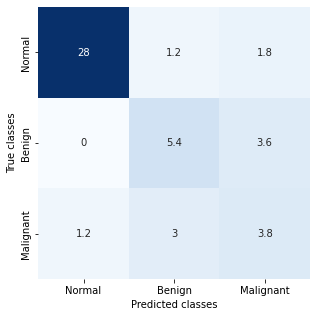

[[28.   1.2  1.8]
 [ 0.   5.4  3.6]
 [ 1.2  3.   3.8]]


In [171]:
class_names = ['Class 0', 'Class 1', 'Class 2']
total_cm = np.zeros((len(class_names), len(class_names)))

# Loop over the classification reports and confusion matrices and add them to the running totals
for cm in confusion_matrices:
    # Add the confusion matrix to the running total
    total_cm += cm
avg_cm = total_cm / len(confusion_matrices)

print(avg_cm)
print(type(avg_cm))

# Create confusion matrix
plt.figure(figsize=(5,5))
class_names = ['Normal', 'Benign', 'Malignant']

sns.heatmap(avg_cm, annot=True, fmt='g', cmap='Blues', square=True, cbar=False,xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted classes')
plt.ylabel('True classes')
plt.show()

## save avg confusion matrix

# Save the matrix to a file
np.save('avg_cm.npy', avg_cm)

# Load the matrix from the file
avg_cm = np.load('avg_cm.npy')
print(avg_cm)

## Calculating some metrices based on the averaged confusion matrix

In [175]:
## loading confusion matrix 
conf_mat = np.load('avg_cm.npy')
print(conf_mat)

# Calculate total number of predictions
total_predictions = np.sum(conf_mat)

# Calculate number of correct predictions
correct_predictions = np.sum(np.diag(conf_mat))

# Calculate overall accuracy
accuracy = correct_predictions / total_predictions
print("Overall Accuracy: {:.3f}".format(accuracy))

# Calculate balanced accuracy
class_counts = np.sum(conf_mat, axis=1) ## true instances per class (row marginal - sum over cols)
class_correct_predictions = np.diag(conf_mat) ## true positives (sum over diagoal)
class_accuracy = class_correct_predictions / class_counts.flatten() ## calculate accuracy per class = tp/tp + fn
balanced_accuracy = np.mean(class_accuracy) ## averaging over all class_accuracies = balanced accuracy
print("Balanced Accuracy: {:.3f}".format(balanced_accuracy))

# Compute metrics for each class
metrics_per_class = {} ## dict to store metrices
for i in range(len(conf_mat)):
    tp = conf_mat[i, i] # true positive
    fp = np.sum(conf_mat[:, i]) - tp # false positive (predicted class i but not class i)
    fn = np.sum(conf_mat[i, :]) - tp # false negatives (not predicted class i but class i)
    
    precision = tp / (tp + fp) ## precision of class i = tp / (tp + fp) -> correctly classified out of all predicted
    recall = tp / (tp + fn) ## recall of class i = tp / (tp + fn)  -> correctly classified out of all instances of class i
    f1_score = 2 * (precision * recall) / (precision + recall) ## f1-score = harmonic mean of precision and recall 
    ## store metrices per class
    metrics_per_class[f'Class {i}'] = {
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1_score
    }

## define dict to store macro averages
macro_metrics = {}

# loop over classes
for class_name, metrics in metrics_per_class.items():
    print(f"{class_name}:")
    for metric_name, metric_value in metrics.items(): ## loop over metrices 
        print(f"\t{metric_name}: {metric_value:.3f}") ## print metrics for each class
        macro_metrics[metric_name] = macro_metrics.get(metric_name, 0) + metric_value ## add class-wise metrics to total count

## loop over metrices and print macro average
for k, v in macro_metrics.items():
    macro_metrics[k] = v / len(conf_mat[0])
    print( f"Macro {k}, {round(macro_metrics[k],3)} ")


[[28.   1.2  1.8]
 [ 0.   5.4  3.6]
 [ 1.2  3.   3.8]]
Overall Accuracy: 0.775
Balanced Accuracy: 0.659
Class 0:
	Precision: 0.959
	Recall: 0.903
	F1-score: 0.930
Class 1:
	Precision: 0.562
	Recall: 0.600
	F1-score: 0.581
Class 2:
	Precision: 0.413
	Recall: 0.475
	F1-score: 0.442
Macro Precision, 0.645 
Macro Recall, 0.659 
Macro F1-score, 0.651 


In [ ]:
## 1. parameter tuning - balanced accuracy - for class_weights (done)
## 2. average confusion matrix over min of 10 runs (done)
## 3. shap values (to do) - done? 

In [ ]:
## what I want for avg: 
## - macro-average precision
## - macro-average recall
## - macro-average f1-score
## - overall accuracy
## - balanced accuracy
## precision, recall, f1-score per class


## Generate confusion matrix of first model and plot history

2/2 [==============================] - 1s 338ms/step
[[29  1  1]
 [ 0  6  3]
 [ 1  4  3]]


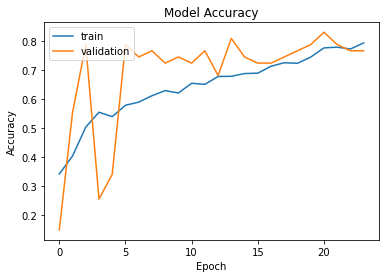

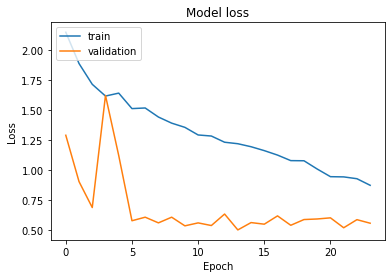

In [176]:
## load model 
model = load_model("best_model.h5")

## get predictions on test set 
preds = model.predict(x_test)
preds_class = np.argmax(preds, axis=1)
obs = np.argmax(y_test, axis=1)

## generate confusion matrix for best model 
cf = confusion_matrix(obs, preds_class)
print(cf)

## [[29  1  1]
 ## [ 0  6  3]
 ## [ 1  4  3]]

## plot model accuracy on train and validation set 
with open('history_best_model.pkl', 'rb') as f:
    history = pickle.load(f)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## plot model loss on train and validation set 
with open('history_best_model.pkl', 'rb') as f:
    history = pickle.load(f)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Evaluate first model 

In [165]:
report = evaluate_model(model,x_test,y_test)
print(report)

2/2 [==============================] - 1s 161ms/step
              precision    recall  f1-score   support

     Class 0       0.97      0.94      0.95        31
     Class 1       0.55      0.67      0.60         9
     Class 2       0.43      0.38      0.40         8

    accuracy                           0.79        48
   macro avg       0.65      0.66      0.65        48
weighted avg       0.80      0.79      0.79        48



## Get model summary

###### model.summary()

## Plot ROC curve of model on test set 

2/2 [==============================] - 1s 227ms/step


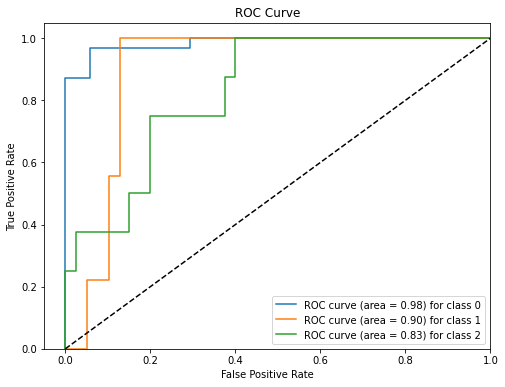

In [177]:
plot_roc_curve(model, x_test, y_test)